<a href = "https://www.pieriantraining.com"><img src="../PT Centered Purple.png"> </a>

<em style="text-align:center">Copyrighted by Pierian Training</em>

# Automatic Blog Post creator

In this project we will build a blog poster that writes a blog post given something to talk about or discuss.
Additionally, a chariming cover photo will be created!

## Imports

In [1]:
import random
import string
from pathlib import Path
import os
import requests
import shutil

from git import Repo
from bs4 import BeautifulSoup as Soup
from openai import OpenAI
from PIL import Image

### Paths:

In [2]:
#PATH_TO_BLOG_REPO = Path("/Users/marci/GIT/OpenAI-API-Python-Course/04-Auto-Blog-Post/b4shy.github.io/.git/")
PATH_TO_BLOG_REPO = Path('C/path/to/.git')
PATH_TO_BLOG = PATH_TO_BLOG_REPO.parent
PATH_TO_CONTENT = PATH_TO_BLOG/"content"
PATH_TO_CONTENT.mkdir(exist_ok=True, parents=True)

In [3]:
PATH_TO_BLOG

PosixPath('/Users/marci/GIT/OpenAI-API-Python-Course/04-Auto-Blog-Post/b4shy.github.io')

## Github Pages

1. Create a new public repository on github named **username.github.io**, where username is github username.
2. Clone the repository
3. Create a new file called **index.html**
4. Add some content to **index.html**
5. Push your changes
6. Goto https://username.github.io

## Automatic updates

Manually adding, commiting and pushing is tedious. Thus we are going to implement functionality that handles everything for us.
Before using openai to generate content for us, we evaluate our code using random strings!

In [4]:
def random_string(length):
    letters = string.ascii_lowercase + "\n"
    
    return ''.join(random.choice(letters) for i in range(length))

random_string(10)

'mwojyxeuxk'

In [5]:
def update_blog(commit_message="Updated blog"):
    repo = Repo(PATH_TO_BLOG_REPO)
    repo.git.add(all=True)
    repo.index.commit(commit_message)
    origin = repo.remote(name='origin')
    origin.push()


Let's create a random text and push it to our blog!

In [6]:
random_blogpost = random_string(1000)

In [7]:
with open(PATH_TO_BLOG/"index.html", "w") as f:
    f.write(random_blogpost)

In [8]:
update_blog()

Now, let's check if our blog got updated! Note that it might take a minute or two.

One problem remains: We always overwrite the starting page!
It would be much better to create a new html file and create a link to this file on the homepage. 
Ideally, the routine would automatically assign a file name and make sure that nothing is overwritten!

In [9]:
def create_new_blog(title, content, cover_image=Path("../PT Centered Purple.png")):
    
    cover_image = Path(cover_image)
    
    files =len(list(PATH_TO_CONTENT.glob("*.html")))
    new_title = f"{files+1}.html"
    path_to_new_content = PATH_TO_CONTENT/new_title
    
    shutil.copy(cover_image, PATH_TO_CONTENT)
    if not os.path.exists(path_to_new_content):
        with open(path_to_new_content, "w") as f:
            f.write("<!DOCTYPE html>\n")
            f.write("<html>\n")
            f.write("<head>\n")
            f.write(f"<title> {title} </title>\n")
            f.write("</head>\n")
            
            f.write("<body>\n")
            f.write(f"<img src='{cover_image.name}' alt='Cover Image'> <br />\n")
            f.write(f"<h1> {title} </h1>")
            f.write(content.replace("\n", "<br />\n"))
            f.write("</body>\n")
            f.write("</html>\n")
            print("Blog created")
            return path_to_new_content
    else:
        raise FileExistsError("File already exist! Abort")

In [10]:
path_to_new_content = create_new_blog("Title", random_string(5000))

Blog created


Now all we have to do in order to access our new blog is to add the link to index.html.
Let's manually overwrite index.html with the following code.

After that we can use beautifulsoup to automatically add the link to index.html

In [15]:
with open(PATH_TO_BLOG/"index.html") as index:
    soup = Soup(index.read())
str(soup)

'<!DOCTYPE html>\n<html>\n<head>\n<title>My Blog</title>\n</head>\n<body>\n<h1>My Blog</h1>\n<a href="index.html">Home</a>\n</body>\n</html>'

In [16]:
def check_for_duplicate_links(path_to_new_content, links):
    urls = [str(link.get("href")) for link in links]
    content_path = str(Path(*path_to_new_content.parts[-2:]))
    return content_path in urls
    

In [17]:
def write_to_index(path_to_new_content):
    with open(PATH_TO_BLOG/"index.html") as index:
        soup = Soup(index.read())

    links = soup.find_all("a")
    last_link = links[-1]
    
    if check_for_duplicate_links(path_to_new_content, links):
        raise ValueError("Link does already exist!")
        
    link_to_new_blog = soup.new_tag("a", href=Path(*path_to_new_content.parts[-2:]))
    link_to_new_blog.string = path_to_new_content.name.split(".")[0]
    last_link.insert_after(link_to_new_blog)
    
    with open(PATH_TO_BLOG/"index.html", "w") as f:
        f.write(str(soup.prettify(formatter='html')))

In [18]:
write_to_index(path_to_new_content)

Last but not least we can push the new blogpost to the repostory!
Again it might take one or two minutes until you can see your changes

In [19]:
update_blog()

## OpenAI API

Remember to use the notebook as shown, you must set your OpenAI API Key as an environment variable. Obviously, there are many ways you could provide your API Key to the Python code, input() or even hard-coded, but those are typically not recommended for safety reasons. Having it as an environment variable let's the key live on the computer, but not actually be present in the code.

In [20]:
client = OpenAI()

### Tell GPT to generate a blogpost
We will tell GPT to generate a blogpost about a topic of interest.

### Prompt Tuning:
To get the best out of GPT, we should inform it about our biography and give some hints about the blogpost. We directly assign a nice and catching title

In [23]:
def system_prompt():
    return "You are a helpful assistant to write blogposts."

def create_prompt(title):
    prompt = """Jose's Website
 
 Biography
 I am a Python instructor teaching people machine learning!


 Blog

 Jan 31, 2023
 Title: Why AI will never replace the radiologist
 tags: tech, machine-learning, radiology
 Summary:  I talk about the cons of machine learning in radiology. I explain why I think that AI will never replace the radiologist.
 Full text: """.format(title)
    return prompt

In [24]:
title = "Why AI will never replace the radiologist"
print(create_prompt(title))

Jose's Website
 
 Biography
 I am a Python instructor teaching people machine learning!


 Blog

 Jan 31, 2023
 Title: Why AI will never replace the radiologist
 tags: tech, machine-learning, radiology
 Summary:  I talk about the cons of machine learning in radiology. I explain why I think that AI will never replace the radiologist.
 Full text: 


### OpenAI API Call
Let's use gpt-3.5-turbo to create the blog post!

In [26]:
response = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": system_prompt()},
    {"role": "user", "content": create_prompt(title)},
  ],
    temperature=0.7
)


In [27]:
blog_content = response.choices[0].message.content


In [28]:
print(blog_content)

Artificial intelligence (AI) has made significant advancements in various fields, including healthcare. In radiology, machine learning algorithms have shown great potential in helping with the diagnosis and analysis of medical images. However, despite these advancements, I firmly believe that AI will never fully replace the radiologist.

One of the main reasons for this is the complexity of the human body and the vast range of conditions that can be detected through medical imaging. While machine learning algorithms can be trained to recognize patterns and anomalies in medical images, they still lack the comprehensive understanding and clinical experience that a radiologist possesses. Radiologists are trained to not only interpret images but also to consider the patient's medical history, symptoms, and other relevant information when making a diagnosis.

Furthermore, radiologists play a crucial role in patient care beyond interpreting images. They often collaborate with other healthcar

### Dalle3 prompt
We will now create the prompt which we pass to dalle3 

In [29]:
def dalle3_prompt(title):
    prompt = f"Pixel art showing '{title}'."
    return prompt

In [30]:
image_prompt = dalle3_prompt(title)
image_prompt

"Pixel art showing 'Why AI will never replace the radiologist'."

In [31]:
response = client.images.generate(
  model="dall-e-3",
  prompt=image_prompt,
  size="1024x1024",
  quality="standard",
  n=1,
)


In [32]:
image_url = response.data[0].url



In [33]:
def save_image(image_url, file_name):
    image_res = requests.get(image_url, stream = True)
    
    if image_res.status_code == 200:
        with open(file_name,'wb') as f:
            shutil.copyfileobj(image_res.raw, f)
    else:
        print("Error downloading image!")
    return image_res.status_code


In [34]:
save_path = "title2.png"

In [35]:
save_image(image_url, save_path)

200

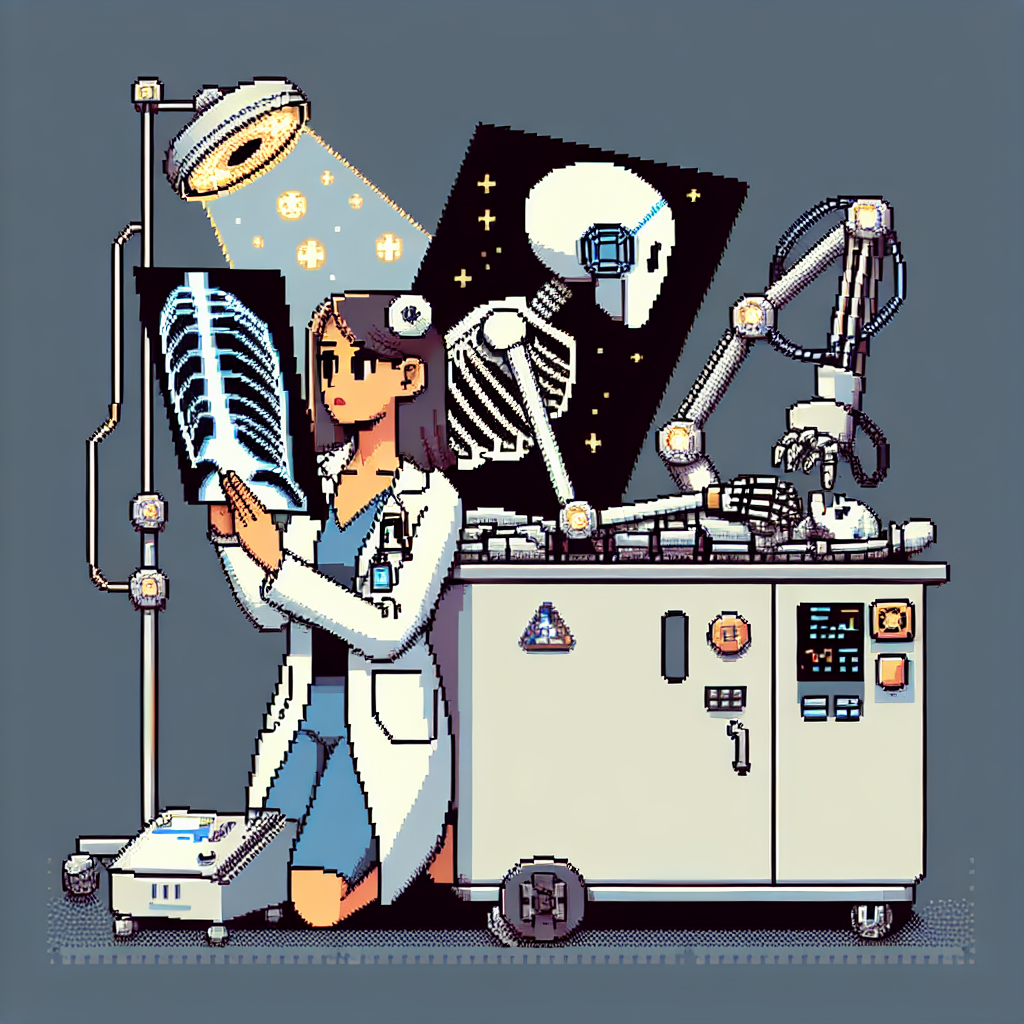

In [36]:
Image.open(save_path)

In [37]:
title

'Why AI will never replace the radiologist'

In [38]:
blog_content

"Artificial intelligence (AI) has made significant advancements in various fields, including healthcare. In radiology, machine learning algorithms have shown great potential in helping with the diagnosis and analysis of medical images. However, despite these advancements, I firmly believe that AI will never fully replace the radiologist.\n\nOne of the main reasons for this is the complexity of the human body and the vast range of conditions that can be detected through medical imaging. While machine learning algorithms can be trained to recognize patterns and anomalies in medical images, they still lack the comprehensive understanding and clinical experience that a radiologist possesses. Radiologists are trained to not only interpret images but also to consider the patient's medical history, symptoms, and other relevant information when making a diagnosis.\n\nFurthermore, radiologists play a crucial role in patient care beyond interpreting images. They often collaborate with other heal

In [39]:
path_to_new_content = create_new_blog(title, blog_content, save_path)

Blog created


In [40]:
write_to_index(path_to_new_content)

In [41]:
update_blog()